In [1]:
import esm

In [2]:
import torch

In [3]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [6]:
# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]

In [7]:
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

In [8]:
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts = True)
token_representations = results["representations"][33]
token_representations

tensor([[[ 0.0744, -0.0747,  0.0824,  ..., -0.2394,  0.1661, -0.0306],
         [ 0.0827, -0.2050, -0.0171,  ...,  0.1045,  0.1343, -0.0946],
         [-0.0528, -0.0635, -0.2515,  ..., -0.0461,  0.2368, -0.1215],
         ...,
         [ 0.0904, -0.0895,  0.0698,  ..., -0.2791,  0.1822, -0.0566],
         [ 0.0960, -0.0847,  0.0673,  ..., -0.2860,  0.1888, -0.0324],
         [ 0.0830, -0.0842,  0.0592,  ..., -0.2927,  0.1853, -0.0333]],

        [[ 0.0819, -0.0513,  0.0804,  ..., -0.3185,  0.1573,  0.0691],
         [-0.0232,  0.0040, -0.2268,  ...,  0.0346,  0.0886,  0.3810],
         [ 0.0146, -0.0701, -0.1314,  ..., -0.0757,  0.3836,  0.0931],
         ...,
         [ 0.0198, -0.1918,  0.1589,  ..., -0.2205, -0.0567,  0.3618],
         [-0.0704, -0.2011,  0.0613,  ..., -0.1973,  0.0557,  0.2920],
         [ 0.1067, -0.0337,  0.0860,  ..., -0.4020,  0.1861,  0.0410]],

        [[ 0.0822, -0.0485,  0.0707,  ..., -0.3181,  0.1576,  0.0736],
         [-0.0306,  0.0160, -0.2225,  ...,  0

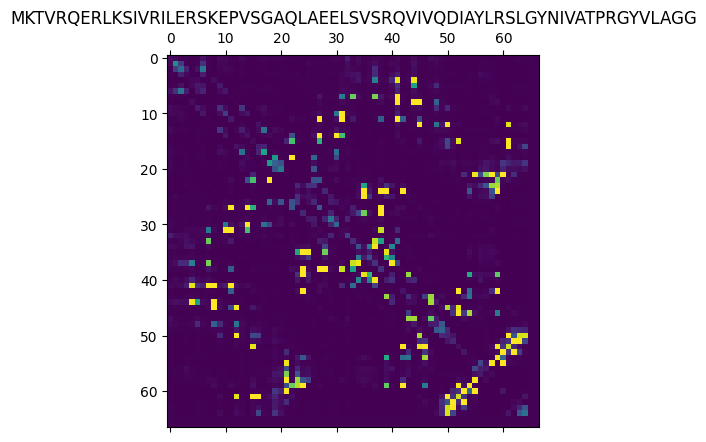

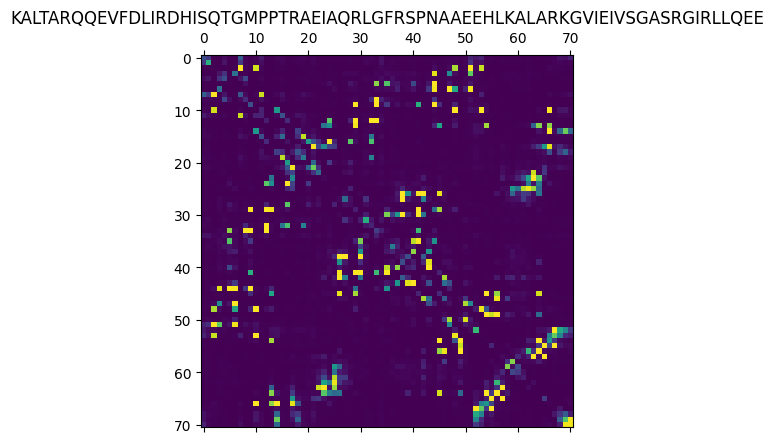

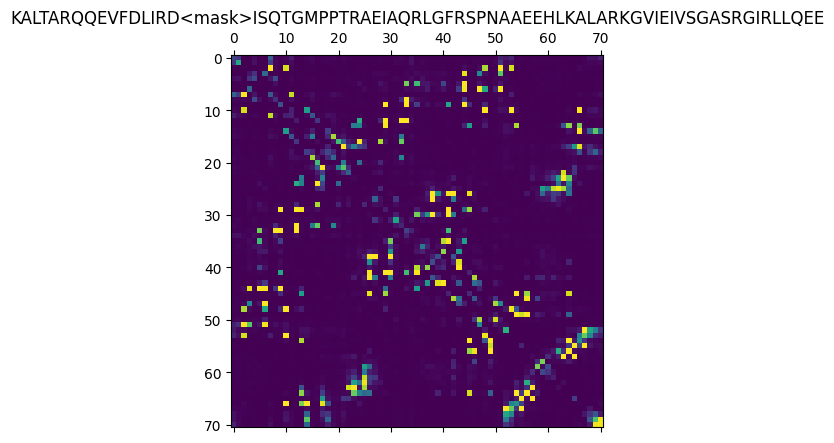

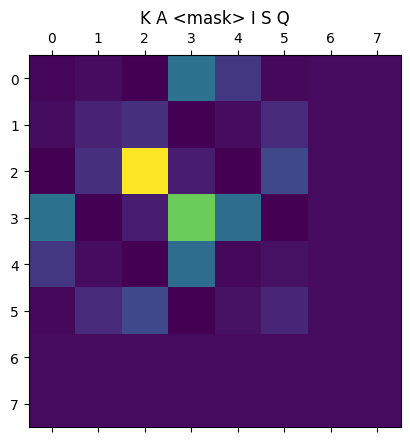

In [11]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()

In [3]:
import torch
import esm

model = esm.pretrained.esmfold_v1()
model = model.eval().cuda()

# Optionally, uncomment to set a chunk size for axial attention. This can help reduce memory.
# Lower sizes will have lower memory requirements at the cost of increased speed.
# model.set_chunk_size(128)

sequence = "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"
# Multimer prediction can be done with chains separated by ':'

with torch.no_grad():
    output = model.infer_pdb(sequence)

with open("result.pdb", "w") as f:
    f.write(output)

import biotite.structure.io as bsio
struct = bsio.load_structure("result.pdb", extra_fields=["b_factor"])
print(struct.b_factor.mean())  # this will be the pLDDT
# 88.3

88.28666007905139


: 

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"  # Set the GPU 2 to use

In [2]:
!pip install biotite

  Using cached biotite-0.39.0.tar.gz (33.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.7/299.7 kB 15.0 MB/s eta 0:00:00
  Created wheel for biotite: filename=biotite-0.39.0-cp37-cp37m-linux_x86_64.whl size=46802044 sha256=949191514a128df10ae2295c19ef8b65812ac0af941674809810cf0c951e6fb2
  Stored in directory: /home/guest1/.cache/pip/wheels/e7/b3/7e/75c891aef29b96e0837059feef20f5da43b3d7b1ed8bb2cd45
Successfully built biotite


In [ ]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.version()) # cudnn 버전
print(toch.cuda.current_device()) # 현재 사용중인 gpu. 0번부터 셈